#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

In [1]:
!pip install pyyaml h5py

# Read the CSV and Perform Basic Data Cleaning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_stock1 = pd.read_csv("../static/data/cba.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/01/2000,26.088652,26.088652,26.088652,26.088652,7.993308,0
1,4/01/2000,26.058813,26.058813,25.720646,25.790268,7.901886,1018072
2,5/01/2000,25.353634,25.392424,25.113932,25.213392,7.725136,2191283
3,6/01/2000,25.362585,25.362585,24.666357,24.716087,7.572770,1505531
4,7/01/2000,24.913021,25.113932,24.735979,24.964741,7.648952,1414040


<AxesSubplot:>

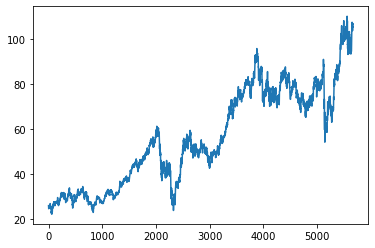

In [4]:
df["Close"].plot()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5673 entries, 0 to 5672
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5673 non-null   object 
 1   Open       5673 non-null   float64
 2   High       5673 non-null   float64
 3   Low        5673 non-null   float64
 4   Close      5673 non-null   float64
 5   Adj Close  5673 non-null   float64
 6   Volume     5673 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 354.6+ KB


In [6]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5673, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [7]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4539, 1)

In [8]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.04184307, 0.03844119, 0.03186422, 0.02619443, 0.02902934,
       0.03583307, 0.03112717, 0.0329982 , 0.03073027, 0.03450637,
       0.0379876 , 0.03712579, 0.03129727, 0.03469913, 0.03390536,
       0.03469913, 0.0329982 , 0.0329982 , 0.03776081, 0.04218326,
       0.04036892, 0.03544755, 0.03531146, 0.03016329, 0.03424555,
       0.03549291, 0.03408679, 0.03696705, 0.04090187, 0.0449728 ,
       0.04610676, 0.05227547, 0.04921377, 0.04036892, 0.04110597,
       0.03708043, 0.0399607 , 0.04127609, 0.03932567, 0.03889476,
       0.03056017, 0.02780467, 0.03696705, 0.03526612, 0.03062821,
       0.02789536, 0.0244935 , 0.0244935 , 0.0244935 , 0.00521622,
       0.00657697, 0.00635016, 0.01099939, 0.0086521 , 0.00521622,
       0.00510283, 0.00147414, 0.00136076, 0.00011341, 0.00100922])]
[0.002086477591719982]


# Prepare train data for LSTM model

In [9]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4479, 60)

In [10]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4479, 60, 1)

# Build the LSTM model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4479/4479 [==============================] - 56s 12ms/step - loss: 7.5443e-04


In [14]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [15]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [16]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [17]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

2.435877968866688

C:\Users\antoi\AppData\Local\Temp/ipykernel_19480/3034226366.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


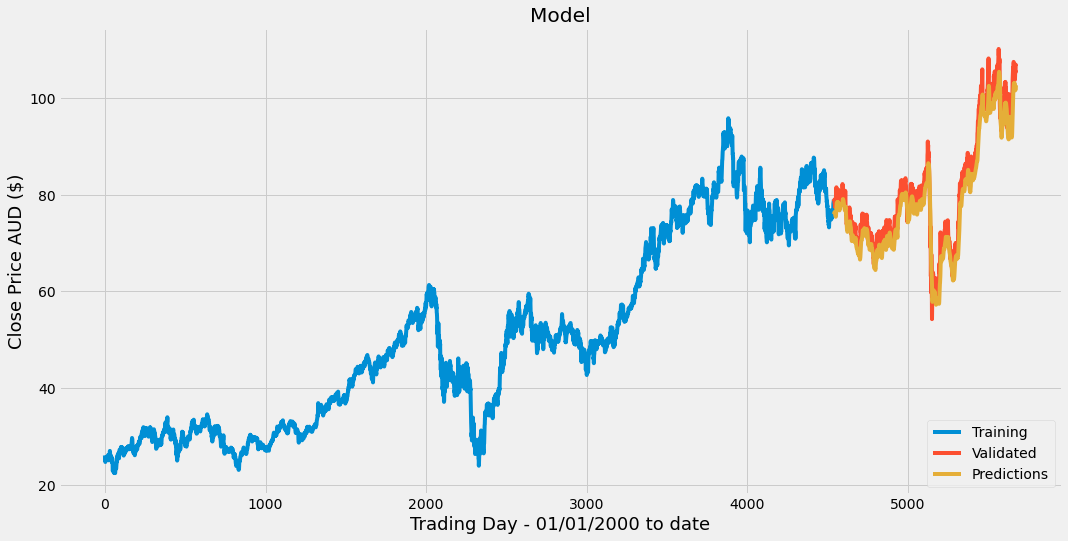

In [18]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Trading Day - 01/01/2000 to date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validated','Predictions'],loc='lower right')
plt.show()


# Test data Predictions on the Model

In [19]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_19480/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4539,78.690002,75.960045,2.729957
4540,78.660004,76.171051,2.488953
4541,78.629997,76.281837,2.348160
4542,78.989998,76.328415,2.661583
4543,78.239998,76.417076,1.822922
...,...,...,...
5668,105.239998,101.630928,3.609070
5669,105.379997,101.719475,3.660522
5670,106.879997,101.834641,5.045356
5671,106.709999,102.253258,4.456741


In [20]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'CBA.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 

In [21]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days_val = stock_close_sixty[-60:].values
last_60_days = last_60_days_val.reshape(-1,1)
last_60_days .shape

(60, 1)

In [22]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [23]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 102


In [24]:
#stock_quote_acual = web.DataReader('CBA.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one


,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED
5673,14/04/2022,105.910004,107.105003,105.830002,106.5,106.5,1393778,NEGATIVE,0.05,0.08


In [25]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
actual_price
actual_date


'14/04/2022'

# Save the Model

In [26]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/cba_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list_cba_sixty and load df

In [27]:
# Read in the CSV file
df_cba_sixty = pd.read_csv("../static/data/cba_sixty.csv")
df_cba_sixty.head()

,99.330002
0,98.610001
1,97.370003
2,97.440002
3,95.449997
4,93.779999


In [28]:
close_sixty_val = df_cba_sixty[-60:].values
last_sixty = close_sixty_val.reshape(-1,1)
last_sixty.shape

(60, 1)

In [29]:
last_sixty_scaled = scaler.transform(last_sixty)
new_X_tell = []
new_X_tell.append(last_sixty_scaled)
new_X_tell =np.array(new_X_tell)
new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
new_X_tell.shape

(1, 60, 1)

In [30]:
#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model

In [32]:
model_in = load_model('cba_model.sav')

In [33]:
model_in_pd_scale = model_in.predict(new_X_tell)
model_in_pd_scale

array([[0.9285438]], dtype=float32)

In [34]:
model_in_price = scaler.inverse_transform(model_in_pd_scale)
#model_in_price_int = int(model_in_price)
print(f'Predicted next day share price {model_in_price}')

Predicted next day share price [[103.86247]]


In [35]:
last_sixty_less_one = np.delete(last_sixty, 0, 0)
last_sixty_less_one.shape

(59, 1)

In [36]:
last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0)
last_sixty.shape

(60, 1)

#Create a function to loop through the days input

In [48]:
from keras.models import load_model
model_in = load_model('cba_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# Read in the CSV file
df_cba_sixty = pd.read_csv("../static/data/cba_sixty.csv")
close_sixty_val = df_cba_sixty[-60:].values
last_sixty = close_sixty_val.reshape(-1,1)
price_list=[]

#Function to predict future days predicted price, in loop
input = 80 #days
if input == "":
    input = 1
else:
   input = int(input)

def predict_cba(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)

In [41]:
n = 2.3336
n = float(n)
n = round(n,2)
n

2.33

In [49]:
predict_cba(last_sixty,model_in,input)

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

#Save predicted price to MongoDB

In [46]:
# # Module used to connect Python with MongoDb
# import pymongo

In [47]:
# # The default port used by MongoDB is 27017
# # https://docs.mongodb.com/manual/reference/default-mongodb-port/
# conn = 'mongodb://localhost:27017'
# client = pymongo.MongoClient(conn)

# # Define the 'sharesDB' database in Mongo
# db = client.sharesDB

In [48]:
# # Query all
# # Here, db.companys refers to the collection 'companys '
# companys = db.companys.find()

# # Iterate through each company in the collection
# for company in companys:
#     print(company)

In [49]:
# # Set keys and values of company
# name = 'CBA'
# predicted = int(pred_price)
# difference = pred_price-actual_price
# print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}')

In [50]:
# # Insert a document into the 'companys' collection
# db.companys.insert_one(
#     {
#       'model': 'LSTM',
#       'name': name,
#       'date': actual_date,
#       'predicted': predicted,
#       'actual': actual_price,
#       'differece': difference
#     }
# )

# # query the classroom collection
# companys = db.companys.find()

# # see change in collection
# for company in companys:
#     print(company)

In [51]:
# # Delete a document from a collection
# db.companys.delete_one(
#     {'name': 'CBA'}
# )

# # query the companys collection
# companys = db.companys.find()

# # see change in the collection
# for company in companys:
#     print(company)

In [52]:
# from pymongo import MongoClient
# mongoClient = MongoClient()
# db = mongoClient.sharesDB
# db.cba.drop()

# import csv
# header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
# csvfile = open('../static/data/cba.csv', 'r')
# reader = csv.DictReader( csvfile )

# for each in reader:
#     row={}
#     for field in header:
#         row[field]=each[field]
        
#     print (row)
#     db.cba.insert_one(row)				 				

In [53]:
# # query the collection
# cbas = db.cba.find()

# # see change in collection
# for cba in cbas:
#     print(cba)

In [54]:
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB
db.cba_scatter.drop()

import csv
header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
csvfile = open('../static/data/cba_scatter.csv', 'r')
reader = csv.DictReader( csvfile )

for each in reader:
    row={}
    for field in header:
        row[field]=each[field]
        
    print (row)
    db.cba_scatter.insert_one(row)				 				

{'Date': '4/01/2022', 'Open': '102', 'High': '102.82', 'Low': '101.300003', 'Close': '102.510002', 'Adj Close': '100.706886', 'Volume': '2195465', 'SENTIMENT': 'POSITIVE', 'RBA': '0.05', 'FED': '0.08'}
{'Date': '5/01/2022', 'Open': '103.279999', 'High': '103.480003', 'Low': '102.620003', 'Close': '103.199997', 'Adj Close': '101.384743', 'Volume': '2086996', 'SENTIMENT': 'NEGATIVE', 'RBA': '0.05', 'FED': '0.08'}
{'Date': '6/01/2022', 'Open': '102.800003', 'High': '103.129997', 'Low': '99.779999', 'Close': '99.970001', 'Adj Close': '98.211563', 'Volume': '2603548', 'SENTIMENT': 'POSITIVE', 'RBA': '0.05', 'FED': '0.08'}
{'Date': '7/01/2022', 'Open': '101.989998', 'High': '102.870003', 'Low': '101.889999', 'Close': '102.650002', 'Adj Close': '100.844421', 'Volume': '2596039', 'SENTIMENT': 'POSITIVE', 'RBA': '0.05', 'FED': '0.08'}
{'Date': '10/01/2022', 'Open': '102.870003', 'High': '103.32', 'Low': '102.080002', 'Close': '103.32', 'Adj Close': '101.502632', 'Volume': '1467407', 'SENTIMENT'